<h3> Cinemática Inversa </h3>

$\theta_1 = tan^{-1}\left(\frac{y}{x}\right)$ 

$r^2 = (z-d_1)^2 + (y\sin\theta_1)^2$

$cos\theta_3 = \frac{r^2 - a_2^2 - a_3^2}{2a_2a_3}$

$\theta_3 = tan^{-1}\left(\frac{\sqrt{1-cos^2\theta_3}}{\cos\theta_3}\right)$

$\theta_2 = \tan^{-1}\left(\frac{z-d_1}{y\sin\theta_1}\right) - \tan^{-1}\left(\frac{a_3\sin\theta_3}{a_2 + a_3\cos\theta_3}\right)$

In [1]:
#************************************************#
# File:        sim.py                            #
# Description: library with functions to control #
#              a RRR manipulator robot           #
# Created:     06/05/2023                        #
# Reviewed:    06/05/2023                        #
#************************************************#

# Import libraries
import numpy as np
import sympy as sym
import pandas as pd

# Import functions
from numpy import sin, cos, arctan2, sqrt

# Robot dimensions
d1 = 0
a2 = 2
a3 = 2

# Denavit-Hartenberg Table
denavit_hartenberg = pd.DataFrame(data={
    "a":     [0, a2, a3],
    "alpha": [np.pi/2, 0, 0],
    "d":     [d1, 0, 0],
    "theta": sym.symbols("theta_1, theta_2, theta_3")
})


def inverse_kinematics(x: float, y: float, z: float) -> np.array:

    """
        Calculates the joint angles required for a robotic arm 
        to reach a specific point in 3D space.

        Args:
            - x: x-coordinate of the target point.
            - y: y-coordinate of the target point.
            - z: z-coordinate of the target point.

        Returns:
            A tuple of three float values representing the joint
            angles (in radians) required to reach the target point.
    """

    # Calculate the joint angles
    theta_1 = arctan2(y, x)
    r2 = (z - d1)**2 + (y * sin(theta_1))**2
    cos_theta_3 = (r2 - a2**2 - a3**2)/(2 * a2 * a3)
    theta_3 = arctan2(sqrt(1-cos_theta_3**2), cos_theta_3)
    temp1 = arctan2((z - d1), (y * sin(theta_1)))
    temp2 = arctan2((a3 * sin(theta_3)), (a2 + a3*cos(theta_3)))
    theta_2 = temp1 - temp2

    # Return the joint angles as a tuple
    return np.array((theta_1, theta_2, theta_3))

def get_homogeneous_matrices(denavit_hartenberg: pd.DataFrame) -> list:

    """
        Computes a list of transformation matrices based on the 
        Denavit-Hartenberg convention.

        Args:
            - denavit_hartenberg: A pandas DataFrame containing the Denavit-Hartenberg parameters 
                                  for each joint in the robot arm. The DataFrame should have four 
                                  columns: 'a', 'alpha','d', and 'theta'. Each row represents one joint.

        Returns:
            A list of sympy Matrix, where each matrix represents the 
            transformation matrix for one joint. 
    """

    Hs = []
    for _, value in denavit_hartenberg.iterrows():
        a, alpha, d, theta = value.values
        Hs.append(sym.Matrix([
            [sym.cos(theta), -sym.sin(theta)*sym.cos(alpha), sym.sin(theta)*sym.sin(alpha), a*sym.cos(theta)],
            [sym.sin(theta), sym.cos(theta)*sym.cos(alpha), -sym.cos(theta)*sym.sin(alpha), a*sym.sin(theta)],
            [0, sym.sin(alpha), sym.cos(alpha), d],
            [0, 0, 0, 1]
        ]))
    return Hs

def forward_kinematics(theta_1: float, theta_2: float, theta_3: float):

    """
        Compute the forward kinematics of a 3-joint robot arm.

        Args:
            - theta_1 (float): The angle (in radians) of joint 1.
            - theta_2 (float): The angle (in radians) of joint 2.
            - theta_3 (float): The angle (in radians) of joint 3.

        Returns:
            A tuple with SymPy Matrices that are the transformation 
            matrices, representing the position and orientation of 
            the robot end effector with respect to the base frame.
    """
    
    A1, A2, A3 = get_homogeneous_matrices(denavit_hartenberg)

    # Define symbolic variables for the joint angles
    t1, t2, t3 = sym.symbols("theta_1, theta_2, theta_3")

    # Get transformation matrices from Denavit-Hartenberg
    T_0_to_1 = A1.subs({t1: theta_1})
    T_0_to_2 = (A1*A2).subs({t1: theta_1, t2: theta_2})
    T_0_to_3 = (A1*A2*A3).subs({t1: theta_1, t2: theta_2, t3: theta_3})

    return(T_0_to_1, T_0_to_2, T_0_to_3)

(0.0, 5.0)

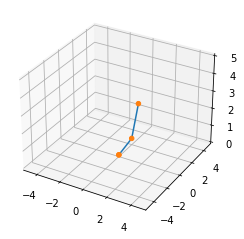

In [34]:
import matplotlib.pyplot as plt

x, y, z = 0, 3, 2
theta_1, theta_2, theta_3 = inverse_kinematics(x, y, z)
T_01, T_02, T_03 = forward_kinematics(theta_1, theta_2, theta_3)

# Separate in x, y, z list
x = [0, T_01[0, 3], T_02[0, 3], T_03[0, 3]]
y = [0, T_01[1, 3], T_02[1, 3], T_03[1, 3]]
z = [0, T_01[2, 3], T_02[2, 3], T_03[2, 3]]

# Plotting
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(projection="3d")
ax.plot(x, y, z)
ax.scatter(x, y, z, color="C1", alpha=1)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_zlim(0, 5)

In [3]:
T_03

Matrix([
[-0.107548470967097, -0.698880051505721,    0.707106781186547, 1.0],
[-0.107548470967097, -0.698880051505721,   -0.707106781186548, 1.0],
[ 0.988365647311398, -0.152096506254158, 6.12323399573677e-17, 3.0],
[                 0,                  0,                    0,   1]])